In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import rcParams
rcParams['figure.figsize'] = 11.7,8.27
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/mtg-all-cards/all_mtg_cards.csv


In [2]:
all_mtg_cards = pd.read_csv("/kaggle/input/mtg-all-cards/all_mtg_cards.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3552: DtypeWarning: Columns (18) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
#  Избавляюсь от дубликатов ориентируясь на название карточки
non_duplicates = all_mtg_cards.drop_duplicates('name')
non_duplicates.color_identity.value_counts().head(6)

['B']         3649
['W']         3624
['R']         3605
['U']         3596
['G']         3543
['B', 'R']     335
Name: color_identity, dtype: int64

In [4]:
# Для мультицветовых карт и карт без цвета выделяю отдельные категории: Multi, None соответственно
def color_to_category(x):
    try:
        size = len(x)
        if(size == 0):
            return "None"
        elif(size == 1):
            return x[0]
        else:
            return "Multi"
    except:
        return "None"
non_duplicates["overall_color"] = non_duplicates["color_identity"].apply(str)
non_duplicates["overall_color"] = non_duplicates["overall_color"].apply(lambda x: "[]" if x == "nan" else x)
non_duplicates["overall_color"] = non_duplicates["overall_color"].apply(eval)
non_duplicates["overall_color"] = non_duplicates["overall_color"].apply(color_to_category)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata

In [5]:
#  Присваиваю массу карте в зависимости от редкости где 1 это Uncommon, 2 это Common, 3 это Rare, 4 это Mythic, 5 это Special 
def mass_rarity(x):
    try:
        mass = x
        if(mass == 'Uncommon'):
            return 1
        elif(mass == 'Common'):
            return 2
        elif(mass == 'Rare'):
            return 3
        elif(mass == 'Mythic'):
            return 4
        elif(mass == 'Special'):
            return 5
    except:
        pass
non_duplicates["mass_rarity"] = non_duplicates["rarity"].apply(mass_rarity)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()


In [6]:
#  Для удобства создаю отдельный датафрейм
overall_color = pd.get_dummies(non_duplicates.overall_color)
rarity = pd.DataFrame(non_duplicates.rarity)
name = pd.DataFrame(non_duplicates.name)
rarity_color = pd.concat([name, overall_color, rarity],axis=1)
#rarity_color = pd.concat([rarity_color, non_duplicates.mass_rarity],axis=1)

#  1. Распределение карт по цвету в зависимости от редкости

In [7]:
df = rarity_color.groupby('rarity').sum()
df

,B,G,Multi,None,R,U,W
rarity,,,,,,,
Common,1437.0,1407.0,662.0,628.0,1417.0,1412.0,1452.0
Mythic,136.0,129.0,482.0,100.0,134.0,133.0,132.0
Rare,1036.0,975.0,1281.0,973.0,1011.0,1026.0,1002.0
Special,0.0,0.0,0.0,2.0,2.0,0.0,1.0
Uncommon,1040.0,1032.0,1188.0,788.0,1041.0,1025.0,1037.0


#  -------------------------------------------------------------------------------------------------------------------------

In [8]:
#non_duplicates.columns
#for i in non_duplicates:
#    df_filter = pd.DataFrame(non_duplicates[i]).head(10)
#    print(df_filter)

In [9]:
# Создаю колонку 'commander', так как интерес представляют запрещенные карты 0 - это карта в формате Commander разрешена, 1 - запрещена
import re
def legalities_if_true(x):
    try:
        legalities = x
        if re.search(r"'format': 'Commander', 'legality': 'Legal'", x):
            return 0
        else:
            return 1
    except:
        pass
non_duplicates["commander"] = non_duplicates["legalities"].apply(legalities_if_true)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == "":


In [10]:
#  Количество карт разрешенных в формате 'commander'
non_duplicates.commander.count()

23151

In [11]:
non_duplicates.type.value_counts()
#  Из оффицальной wiki mgt 
#  Всего типов карт в MTG семь: 
#  Земля (Land), 
#  Существо (Creature), 
#  Артефакт (Artifact), 
#  Чары (Enchantment), 
#  Волшебство (Sorcery), 
#  Мгновенное заклинание (Instant) и 
#  Planeswalker. 
#  Земли, Существа, Артефакты, Чары и Planeswalker’ы — это перманенты, то есть карты, которые после разыгрывания остаются на поле боя
#  На это и ориентируюсь

Instant                                2790
Sorcery                                2594
Enchantment                            1442
Artifact                               1122
Enchantment — Aura                     1008
                                       ... 
Artifact Creature — Food Golem            1
Creature — Elf Knight Ranger              1
Creature — Skeleton Knight                1
Legendary Planeswalker — Will Rowan       1
Creature — Cat Horror                     1
Name: type, Length: 2369, dtype: int64

In [12]:
#  Создаю колонку 'main_types' в которую будут входить 7 выше перечисленных типов карт
def sort_main_types(x):
    try:
        if re.search(r"Land", x):
            return 'Land'
        elif re.search(r"Creature", x):
            return 'Creature'
        elif re.search(r"Artifact", x):
            return 'Artifact'
        elif re.search(r"Enchantment", x):
            return 'Enchantment'
        elif re.search(r"Sorcery", x):
            return 'Sorcery'
        elif re.search(r"Instant", x):
            return 'Instant'
        elif re.search(r"Planeswalker", x):
            return 'Planeswalker'
        else:
            return 
    except:
        return 
non_duplicates["main_types"] = non_duplicates["type"].apply(sort_main_types)
    

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [13]:
#  Получил отсортированные по типам карты
non_duplicates.main_types.value_counts()

Creature        12823
Instant          2900
Enchantment      2672
Sorcery          2669
Artifact         1670
Land              810
Planeswalker      261
Name: main_types, dtype: int64

#  2 Процент карт, запрещенных в формате Commander, а также распределение по типу для этих карт

In [14]:
count = non_duplicates.name.count() # Колличество уникальных карт
banned_commander = count - non_duplicates.commander.count() # Колличество запрещенных в формате Commander карт
procent_ban_commander = banned_commander / count * 100
procent_ban_commander

4.021392147920898

# Процент карт, запрещенных в формате Commander равен 4.02%

In [15]:
main_types = pd.DataFrame(non_duplicates.main_types)
commander = pd.DataFrame(non_duplicates.commander)
precent_of_ban_from_type = pd.concat([commander, main_types],axis=1)

#  Распределение карт по типу для запрещенных в формате Commander

<AxesSubplot:xlabel='commander', ylabel='main_types'>

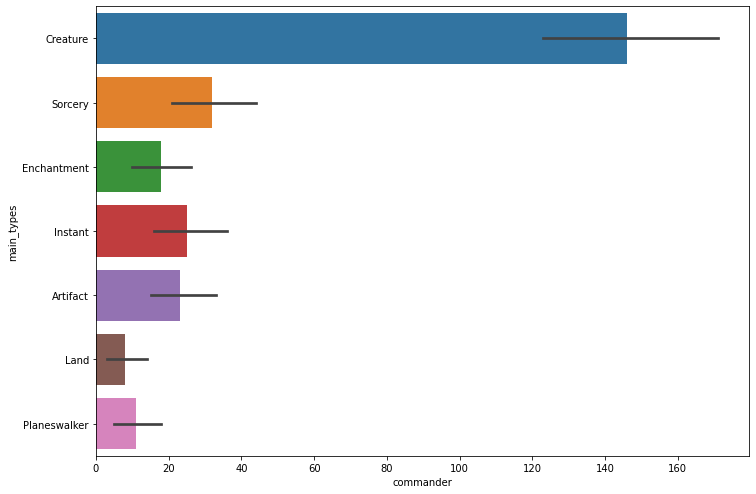

In [16]:
#  barplot показывающий распределение запрещенных в формате Commander в зависимости от типа карт
sns.barplot(data=precent_of_ban_from_type, x="commander", y="main_types", estimator=np.sum)

#  -------------------------------------------------------------------------------------------------------------------------

In [17]:
#  Так как меня интересует Топ-10 карт, не являющихся землями - избавляемся от этих карт(land)


non_land_df = non_duplicates.set_index('main_types').drop(['Land'], axis=0)

In [18]:
#  Мне интересна колонка printings, так как в ней указаны сеты в которых печатальсь карты


def count_printings(x):
    return len(x)
non_land_df['count_printings'] = non_land_df['printings'].str.split(',')
non_land_df['count_printings'] = non_land_df['count_printings'].apply(count_printings) # в колонке count_printings будет указано в скольких наборах применялась данная карточка

In [19]:
# Сотрирую датафрейм по убыванию от часто упоминаемых карт

sort_non_land_df = non_land_df.sort_values(by=['count_printings'], ascending=False)

#  3 Топ-10 карт, не являющихся землями, которые были напечатаны в наибольшем количестве сетов

In [20]:
top_ten = sort_non_land_df.head(10)
pd.DataFrame(top_ten[['name', 'count_printings']])

,name,count_printings
main_types,,
Instant,Giant Growth,47
Instant,Counterspell,46
Creature,Serra Angel,42
Instant,Swords to Plowshares,42
Instant,Dark Ritual,41
Artifact,Sol Ring,41
Instant,Disenchant,41
Creature,Llanowar Elves,40
Sorcery,Fireball,35


<AxesSubplot:xlabel='count_printings', ylabel='name'>

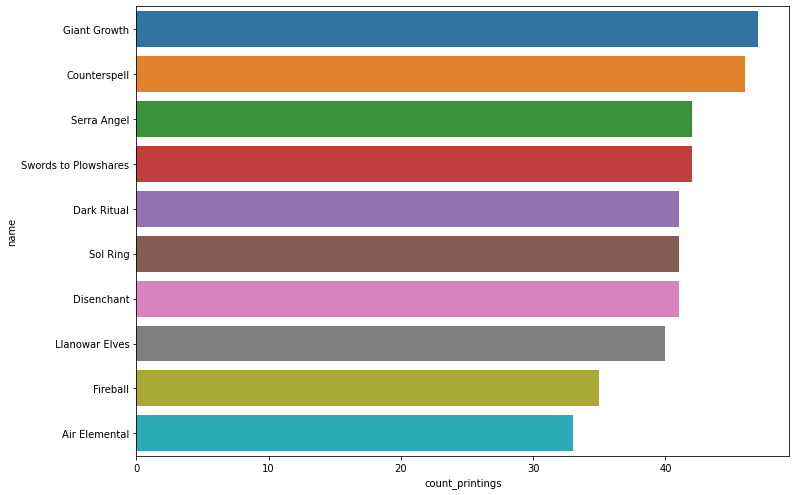

In [21]:
sns.barplot(data=top_ten, x="count_printings", y="name", estimator=np.sum)

#  -------------------------------------------------------------------------------------------------------------------------

In [22]:
# Использую датафрейм с исключенными картами типа Land


non_land_df = non_land_df.reset_index()
non_land_df.head(5)

,main_types,name,multiverse_id,layout,names,mana_cost,cmc,colors,color_identity,type,...,legalities,source,image_url,set,set_name,id,overall_color,mass_rarity,commander,count_printings
0,Creature,Ancestor's Chosen,130550.0,normal,NaN,{5}{W}{W},7.0,['White'],['W'],Creature — Human Cleric,...,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,5f8287b1-5bb6-5f4c-ad17-316a40d5bb0c,W,1,0.0,3
1,Creature,Angel of Mercy,129465.0,normal,NaN,{4}{W},5.0,['White'],['W'],Creature — Angel,...,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,57aaebc1-850c-503d-9f6e-bb8d00d8bf7c,W,1,0.0,13
2,Sorcery,Angelic Blessing,129711.0,normal,NaN,{2}{W},3.0,['White'],['W'],Sorcery,...,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,55bd38ca-dc73-5c06-8f80-a6ddd2f44382,W,2,0.0,9
3,Enchantment,Angelic Chorus,129710.0,normal,NaN,{3}{W}{W},5.0,['White'],['W'],Enchantment,...,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,3b77bb52-4181-57f5-b3cd-f3a15b95aa29,W,3,0.0,3
4,Creature,Angelic Wall,129671.0,normal,NaN,{1}{W},2.0,['White'],['W'],Creature — Wall,...,"[{'format': 'Commander', 'legality': 'Legal'},...",NaN,http://gatherer.wizards.com/Handlers/Image.ash...,10E,Tenth Edition,fadda48c-6226-5ac5-a2b9-e9170d2017cd,W,2,0.0,5


#  4 Для карт, не являющихся землями, определите, какая часть из них даёт ману с помощью своего эффекта. Покажите распределение по типу маны, который дают эти карты. 

In [23]:
# Чтобы выяснить какие карты дают ману, веду поиск пользуясь регулярным выражением "add {", карты не соответствующие условию, помечаются как NaN


def ifna(x):
    try:
        ifna = x
        if re.search(r"add {", x):
            return x
        else:
            return "NaN"
    except:
        return "NaN"
non_land_df["add_mana"] = non_land_df["text"].apply(ifna)

#  Получилось 49 карт даюших ману с помощью своего эффекта, общее количество карт не являющихся землями равно 23311

In [24]:
#  Избавляюсь от карт со значением NaN так как эти карты меня не интересуют


df = non_land_df.set_index('add_mana').drop('NaN').reset_index()
df.name.count()  


#  Получилось 49 карт даюших ману

49

In [25]:
# Считаю часть карт даёт ману с помощью своего эффекта от общего количества карт
pie = df.name.count() / non_land_df.name.count() * 100
pie

0.21020119257003134

#  Соотношение карт которые дают ману с помощью своего эффекта к общему количеству равно 0.21%

In [26]:
# Пользуясь регуляркой отбираю интересующие меня значения с типом маны (B. W. R. G. C. U)


def get_mana(x):
    try:
        results = re.findall(r"\{[BWRGCU].*?\}", x)
        return results
    except:
        return NaN
        
        
df["get_mana"] = df["add_mana"].apply(get_mana)

#  Распределение по типу маны, который дают эти карты

In [27]:
from collections import Counter
counter = Counter()

for i in df['get_mana'].values:
    counter.update(i)
    
del counter['{CHAOS}'] #  так как такого типа маны не существует - удаляю

counter = pd.Series(counter)

<AxesSubplot:>

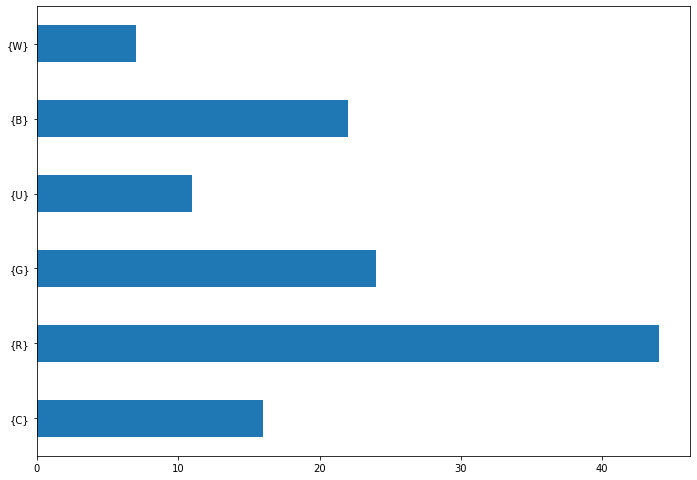

In [28]:
counter.plot.barh()